### CS 421 PROJECT

Team members:
- Emmanuel Oh
- Lee Shiying
- Megan Tan
- Sheffield Lok

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BATCHES_DIR = 'batches/'
PREDS_DIR = 'predictions/'

# Load data from previous batches as training sets
batch1=np.load(BATCHES_DIR+"first_batch.npz")
batch2=np.load(BATCHES_DIR+"second_batch_with_labels.npz")
batch3=np.load(BATCHES_DIR+"third_batch_with_labels.npz")
batch4=np.load(BATCHES_DIR+"fourth_batch_with_labels.npz")

In [29]:
# Convert loaded data into pd.DataFrame objects
X1=pd.DataFrame(batch1["X"], columns=["user", "item", "rating"])
y1=pd.DataFrame(batch1["y"], columns=["user", "label"])
X2=pd.DataFrame(batch2["X"], columns=["user", "item", "rating"])
y2=pd.DataFrame(batch2["y"], columns=["user", "label"])
X3=pd.DataFrame(batch3["X"], columns=["user", "item", "rating"])
y3=pd.DataFrame(batch3["y"], columns=["user", "label"])
X4=pd.DataFrame(batch4["X"], columns=["user", "item", "rating"])
y4=pd.DataFrame(batch4["y"], columns=["user", "label"])


### Exploratory data analysis

In [30]:
def show_metrics(t: str, X: pd.DataFrame):
    real = X.loc[X['label'] == 0]
    fake = X.loc[X['label'] == 1]
    r_real: pd.Series = real['rating']
    r_fake: pd.Series = fake['rating']
    metrics = pd.DataFrame(
        {
            'Status': ['Real', 'Fake'],
            'Count': [len(r_real), len(r_fake)],
            'Mean': [r_real.mean(), r_fake.mean()],
            'Median': [r_real.median(), r_fake.median()],
            'Std': [r_real.std(), r_fake.std()],
            'Min': [r_real.min(), r_fake.min()],
            'Max': [r_real.max(), r_fake.max()]
        }
    )
    print(f'------------------------------------{t}------------------------------------')

    print(metrics)

    n_bins = 6
    fig, axs = plt.subplots(2)
    axs[0].hist(r_real, n_bins)
    axs[1].hist(r_fake, n_bins)
    plt.show()
    

------------------------------------Batch 1------------------------------------
  Status   Count      Mean  Median       Std  Min  Max
0   Real  787553  3.411602     4.0  1.069132    0    5
1   Fake   20100  2.350050     2.0  1.389459    1    5


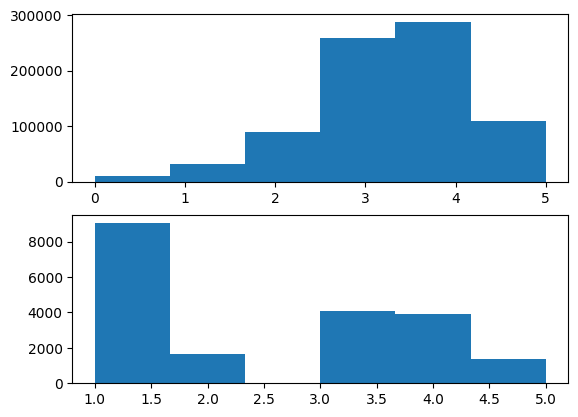

------------------------------------Batch 2------------------------------------
  Status   Count      Mean  Median       Std  Min  Max
0   Real  158421  3.409497     4.0  1.056926    0    5
1   Fake   31782  2.445535     2.0  1.434485    1    5


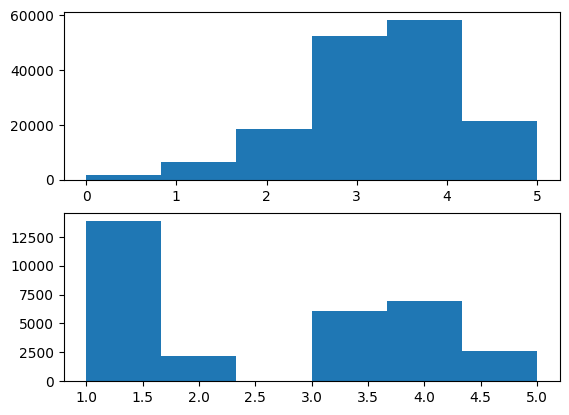

------------------------------------Batch 3------------------------------------
  Status   Count      Mean  Median       Std  Min  Max
0   Real  159687  3.378678     3.0  1.069868    0    5
1   Fake   35726  2.838773     3.0  1.516131    0    5


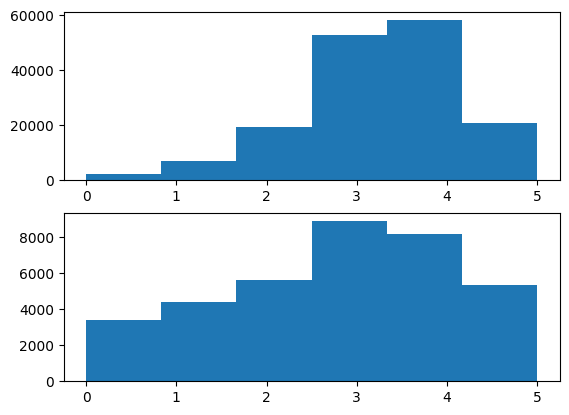

------------------------------------Batch 4------------------------------------
  Status   Count      Mean  Median       Std  Min  Max
0   Real  160604  3.423887     4.0  1.057651    0    5
1   Fake   36192  2.901194     3.0  1.508513    0    5


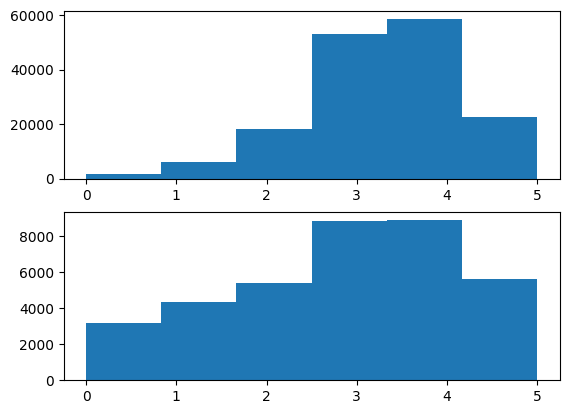

In [31]:
t1 = 'Batch 1'
X1_labeled: pd.DataFrame = pd.merge(X1, y1)
t2 = 'Batch 2'
X2_labeled: pd.DataFrame = pd.merge(X2, y2)
t3 = 'Batch 3'
X3_labeled: pd.DataFrame = pd.merge(X3, y3)
t4 = 'Batch 4'
X4_labeled: pd.DataFrame = pd.merge(X4, y4)

for t, X_labeled in [(t1, X1_labeled), (t2, X2_labeled), (t3, X3_labeled), (t4, X4_labeled)]:
    show_metrics(t, X_labeled)



### Feature engineering, model training and predictions

In [32]:
# Concatenate all previous weeks' batches into a single dataframe each
data_X = [X1, X2, X3, X4]
data_y = [y1, y2, y3, y4]
X = pd.concat(data_X)
y = pd.concat(data_y)


y.drop('user', axis=1, inplace=True)

In [33]:
# Define a function to compute useful features for model fitting
def get_features(X: pd.DataFrame):
  '''Takes in a DataFrame of user-item-rating entries and computes descriptive
  features based on each user's collated reviews


  Features include:
  - Review count
  - Total sum of reviews
  - Standard error of mean
  - Standard deviation
  - 25% quantile
  - 50% quantile
  - 75% quantile
  - mean
  - median
  - max
  - min
  - mode
  

  Returns a DataFrame with computed features for each unique user
  '''
  features = pd.DataFrame(X.groupby('user')['user'].max())
  features['count'] = X.groupby('user')['rating'].count()
  features['sum'] = X.groupby('user')['rating'].sum()
  features['sem'] = X.groupby('user')['rating'].sem()
  features['std'] = X.groupby('user')['rating'].std()
  features['25%'] = X.groupby('user')['rating'].quantile(0.25)
  features['50%'] = X.groupby('user')['rating'].quantile(0.50)
  features['75%'] = X.groupby('user')['rating'].quantile(0.75)
  features['mean'] = X.groupby('user')['rating'].mean()
  features['median'] = X.groupby('user')['rating'].median()
  features['max'] = X.groupby('user')['rating'].max()
  features['min'] = X.groupby('user')['rating'].min()
  features['mode'] = X.groupby('user')['rating'].apply(
      lambda x: x.value_counts().index[0]
    )
  return features


X = get_features(X).fillna(0)
X.head(10)


,user,count,sum,sem,std,25%,50%,75%,mean,median,max,min,mode
user,,,,,,,,,,,,,
0,0,35,126,0.143193,0.847141,3.0,4.0,4.00,3.600000,4.0,5,2,4
1,1,81,283,0.072698,0.654283,3.0,4.0,4.00,3.493827,4.0,5,1,4
2,2,26,71,0.211643,1.079173,2.0,3.0,3.75,2.730769,3.0,5,1,2
3,3,141,467,0.124560,1.479067,3.0,4.0,4.00,3.312057,4.0,5,0,4
4,4,79,216,0.171585,1.525080,1.0,3.0,4.00,2.734177,3.0,5,0,4
5,5,43,187,0.148390,0.973059,4.0,5.0,5.00,4.348837,5.0,5,1,5
6,6,143,472,0.052548,0.628378,3.0,3.0,4.00,3.300699,3.0,4,2,3
7,7,101,380,0.078537,0.789285,3.0,4.0,4.00,3.762376,4.0,5,2,4
8,8,220,812,0.060950,0.904029,3.0,4.0,4.00,3.690909,4.0,5,0,4


In [34]:
from sklearn.model_selection import train_test_split


# Classification/Anomaly Detection methods
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest, RandomForestClassifier


# Model evaluation metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, \
  recall_score, f1_score

In [35]:
# Train-test split
X, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


# Model-fitting
########### Logistic Regression ##########
lr = LogisticRegression()
lr.fit(X, np.ravel(y_train, order='C'))


########### K-Means ##########
# Set n_clusters to 1, as legitimate users should cluster around 1 distribution
N_Kmeans = 1
kmeans = KMeans(n_clusters=N_Kmeans, init='k-means++', max_iter=50, random_state=0)
kmeans.fit(X)

    
########## Gaussian Mixture ##########
# Set n_components to 1 as we treat normal users as a single cluster,
# with fake users as anomalies
N_GMix = 1
gm = GaussianMixture(n_components=N_GMix, random_state=0, covariance_type="full")
gm.fit(X)


########### Isolation Forest ##########
il=IsolationForest(n_estimators=500)
il.fit(X)


########## Random Forest ##########
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, np.ravel(y_train, order='C'))

/Users/emman/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier()

In [36]:
# Predict on test set

scaler=[RobustScaler() for _ in range(N_Kmeans)]
dists_train, centres_train = kmeans.transform(X), kmeans.predict(X)
distnear_train = dists_train[range(centres_train.shape[0]), centres_train]
dists_test, centres_test = kmeans.transform(X_test), kmeans.predict(X_test)
distnear_test = dists_test[range(centres_test.shape[0]), centres_test]
for i in range(N_Kmeans):
    scaler[i].fit(distnear_train[centres_train==i].reshape(-1,1))
for i in range(N_Kmeans):
    distnear_test[centres_test==i] = scaler[i].transform(
        distnear_test[centres_test==i].reshape(-1,1)
    ).reshape(-1)


# For Kmeans and GM, normalize values to lie between 0-1, and take those 
# as predictions
def normalize(X):
  '''Normalizes values `i` in an array `X` to 0-1 by computing 
  `(i - min(x)) / (max(x) - min(x))`
  '''
  dist_min = min(X)
  dist_max = max(X)
  preds = np.array([(i-dist_min)/(dist_max-dist_min) for i in X])
  return preds


y_pred_lr = lr.predict_proba(X_test)[:,1]
y_pred_km = normalize(distnear_test)
y_pred_gm = normalize(-gm.score_samples(X_test))
y_pred_il = -il.score_samples(X_test)
y_pred_rf = rf.predict_proba(X_test)[:,1]

In [37]:
labels = y_test['label']
y_pred_km_disc = np.round(y_pred_km)


print(f"F1: {f1_score(labels, y_pred_km_disc)}")
print(f"Precision: {precision_score(labels, y_pred_km_disc)}")
print(f"Recall: {recall_score(labels, y_pred_km_disc)}")

F1: 0.23971377459749554
Precision: 0.14988814317673377
Recall: 0.5982142857142857


In [38]:
def print_metrics(labels, pred):
    '''Takes in a set of true labels 0-1 and predictions (probabilistic
    or 0-1) and computes key evaluation metrics

    - AUC
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    '''
    print(f"AUC         : {roc_auc_score(labels, pred)}")
    pred_discrete = np.round(pred)
    print(f"Accuracy    : {accuracy_score(labels, pred_discrete)}")
    print(f"Precision   : {precision_score(labels, pred_discrete)}")
    print(f"Recall      : {recall_score(labels, pred_discrete)}")
    print(f"F1          : {f1_score(labels, pred_discrete)}")


labels = y_test['label']
print("------------Logistic Regression------------")
print_metrics(labels, y_pred_lr)
print("------------K Means------------------------")
print_metrics(labels, y_pred_km)
print("------------Gaussian Mixture---------------")
print_metrics(labels, y_pred_gm)
print("------------Isolation Forest---------------")
print_metrics(labels, y_pred_il)
print("------------Random Forest------------------")
print_metrics(labels, y_pred_rf)

------------Logistic Regression------------
AUC         : 0.8791537996777659
Accuracy    : 0.9214285714285714
Precision   : 0.8347107438016529
Recall      : 0.45089285714285715
F1          : 0.5855072463768116
------------K Means------------------------
AUC         : 0.5922115556749016
Accuracy    : 0.532967032967033
Precision   : 0.14988814317673377
Recall      : 0.5982142857142857
F1          : 0.23971377459749554
------------Gaussian Mixture---------------
AUC         : 0.6686190923737916
Accuracy    : 0.8758241758241758
Precision   : 0.0
Recall      : 0.0
F1          : 0.0
------------Isolation Forest---------------
AUC         : 0.6647925617615468
Accuracy    : 0.8115384615384615
Precision   : 0.3169230769230769
Recall      : 0.45982142857142855
F1          : 0.3752276867030966
------------Random Forest------------------
AUC         : 0.9145212361260293
Accuracy    : 0.9340659340659341
Precision   : 0.90625
Recall      : 0.5178571428571429
F1          : 0.6590909090909092


In [39]:
# Final predictions
batch_final=np.load(BATCHES_DIR+"FINAL_batch.npz")
X_final=pd.DataFrame(batch_final["X"], columns=["user", "item", "rating"])
X_final_features = get_features(X_final)

In [40]:
# Apply Random Forest classifier
y_pred_proba_rf = rf.predict_proba(X_final_features)[:,1]
predictions = pd.DataFrame(y_pred_proba_rf, columns=['y_pred'])
# Save output
np.savez(PREDS_DIR+'predictions_FINAL.npz', predictions)